# Setup

In [26]:
import numpy as np
from numpy import linalg as LA
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, fft
import math as math
import os
from matplotlib.patches import Polygon
import copy
import pickle
from scipy.stats import norm,wilcoxon,shapiro,ttest_rel
import statistics


In [105]:
# plotting parameters
#determine colors and font size|
colors = dict(M='#6600CC',
              F='#000000',
              B='#FFFFFF',
              H='#009900',
              r='#FDB119',
              u='#009900',
              u25='#BBF90F',
              u75='#006400',
              d='#FD6E19',
              #y='#0033FF',  #or 6600CC which is darker and I prefer 
              y='#6600CC',  #or 6600CC which is darker and I prefer 
              N='#0000CC',
              D='#CC0000',
              g='#B1B1B1', #grey
              first5='#B1B1B1',
              last5='#999999',
              BLUE = '#1f77b4',
              ORANGE = '#ff7f0e',
              GREEN = '#2ca02c',
              RED = '#d62728',
              PURPLE = '#9467bd',
              GOLD = '#FDB119') #default colors
              # D = dominant = right; N = nondominant = left

yfill = list(matplotlib.colors.to_rgba(colors['y']))
yfill[-1] = 0.3

ufill = list(matplotlib.colors.to_rgba(colors['u']))
ufill[-1] = 0.3

gfill = list(matplotlib.colors.to_rgba(colors['g']))
gfill[-1] = 0.3

rfill = list(matplotlib.colors.to_rgba(colors['r']))
rfill[-1] = 0.3

bfill = list(matplotlib.colors.to_rgba(colors['BLUE']))
bfill[-1] = 0.3

font = {#'family' : 'normal',
        'weight' : 'ultralight',
        'size'   : 14}
matplotlib.rc('font', **font)
from matplotlib import rcParams
rcParams['axes.titlesize'] = 16
rcParams['font.weight'] = 'ultralight'
rcParams['font.family'] = 'sans-serif'
rcParams['mathtext.fontset'] = 'cm'

In [28]:
a_file = open("HCPS.pkl", "rb") #remember to close afterwards
HCPS = pickle.load(a_file)
a_file.close()

b_file = open("DATA.pkl", "rb") #remember to close afterwards
DATA = pickle.load(b_file)
b_file.close()

c_file = open("TF.pkl", "rb") #remember to close afterwards
TF = pickle.load(c_file)
c_file.close()

d_file = open("SIM.pkl", "rb") #remember to close afterwards
SIM = pickle.load(d_file)
d_file.close()

lqg_file = open("LQG_SIM.pkl", "rb") #remember to close afterwards
LQG_SIM = pickle.load(lqg_file)
lqg_file.close()

In [29]:
delta_file = open("AvgDelta.pkl", "rb") #remember to close afterwards
avgdelta = pickle.load(delta_file)
delta_file.close()

In [30]:
# Data analysis
def FFT(data,N):
  return fft.fft(data)/N

def IFFT(data,N):
  return (fft.ifft(data)*N).real
  
M = lambda s : 1/(s**2 + s) #2nd order machine

num_cond = 7 #number of conditions
participants_num = len(HCPS.keys())

#number of trials for each condition
trialnum = [0] * num_cond 
for c in range(num_cond):
  trialnum[c] = len(HCPS['subject0']['condition'+str(c)].keys())         #number of data trials, trial0 ~ trial3

#parameters (same for all three conditions)
fs = 60                               #pygame update rate 60 Hz
base_freq = 0.05                      #1/20 Hz
N = len(HCPS['subject0']['condition0']['trial0']['time_'])    #data length
xf_all = fft.fftfreq(N, 1./ fs)       #freq (x-axis) both + and - terms
xf = fft.fftfreq(N, 1./ fs)[:N//2]    #freq (x-axis) positive-frequency terms
M_h = M(1.j*2*np.pi*xf_all)           #M_hat = 1/ ((jw)^2 + (jw))
t = HCPS['subject0']['condition0']['trial0']['time_']         #time
prime = np.asarray([2, 3, 5, 7, 
                    11, 13, 17, 19])  #prime numbers
stimulated_index = prime*2 #array([ 4,  6, 10, 14, 22, 26, 34, 38])
stimulated_freq = prime*base_freq

T = 40 #final simulation time 
dt = 1/fs #time steps (60Hz) 
scaleOutputScreen = 1/4
scaleInput = 0.04616974606700115

<ipython-input-30-cf8719837387>:8: RuntimeWarning: divide by zero encountered in true_divide
  M = lambda s : 1/(s**2 + s) #2nd order machine
<ipython-input-30-cf8719837387>:8: RuntimeWarning: invalid value encountered in true_divide
  M = lambda s : 1/(s**2 + s) #2nd order machine


## plot functions

In [31]:
import textwrap
def wrap_labels(ax, width, my_labels, break_long_words=False):
    labels = []
    for label in my_labels:
        # text = label.get_text()
        labels.append(textwrap.fill(label, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

In [32]:
def BOXPLOT(data0, title0 ,data1 = None, title1 = None, ylimit0 = None, ylimit1= None, EMGplot = False, Sliderplot = False): # can plot one or two plots
    '''
    data0 and data1: list of 7 arrays, [cond0, cond1, ... cond6]
    '''
    
    # pos = np.array(range(num_cond))+1
    # xticks = pos
    # xticklabels = ['Slider','EMG','50%','25%','75%','Slider2','EMG2']
    # labels = [r'$1^{st}$$\alpha=0$   100:0',r'$1^{st}$$\alpha=1$   0:100',r'$\alpha=0.5$ 50:50',r'$\alpha=0.25$ 75:25',
    #             r'$\alpha=0.75$ 25:75',r'$2^{nd}$$\alpha=0$ 100:0',r'$2^{nd}$$\alpha=1$ 0:100'] #slider : EMG
    # labels = [r'$1^{st}$ $\alpha=0$',r'$1^{st}$ $\alpha=1$',r'$\alpha=0.5$',r'$\alpha=0.25$',
    #             r'$\alpha=0.75$',r'$2^{nd}$ $\alpha=0$',r'$2^{nd}$ $\alpha=1$'] #slider : EMG
    labels = ['100:0','0:100','50:50','75:25','25:75','100:0','0:100'] #slider : EMG
    # labels = [r'$1^{st}$ 100:0',r'$1^{st}$ 0:100',r'50:50',r'75:25',
                # r'25:75',r'$2^{nd}$ 100:0',r'$2^{nd}$ 0:100'] #slider : EMG
    boxcolors = ['white', 'black', 'darkgrey','lightgrey','dimgrey','white', 'black']
    # boxcolors = ['white', 'black', 'silver','whitesmoke','dimgrey','white', 'black']
    # boxcolors = ['white', 'black', 'limegreen','lightgreen','darkgreen','white', 'black']
    # boxcolors = ['white', 'black', 'green','yellowgreen','darkcyan','white', 'black']
    # boxcolors = ['white', 'black', (0.4,1,0.4,0.5), (0.4,1,0.4,0.25), (0.4,1,0.4,0.75),'white', 'black']



    if data1 != None: 
        fig,axs = plt.subplots(1, 2,figsize=(10,5)) 

        # subplot 0
        ax = axs[0]
        bplot = ax.boxplot(data0, widths = 0.5,patch_artist=True,labels=labels)
        for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
            patch.set_facecolor(color)

        ax.title.set_text(title0)
        # ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
        if ylimit0 is not None: 
            ax.set_ylim(0,ylimit0)
            
        ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
        ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)

        # subplot 1
        ax = axs[1]
        bplot = ax.boxplot(data1, widths = 0.5,patch_artist=True,labels=labels)
        for patch, color in zip(bplot['boxes'], boxcolors):
            patch.set_facecolor(color)

        ax.title.set_text(title1)
        # ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
        if ylimit1 is not None:
            ax.set_ylim(0,ylimit1)
        
        ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
        ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)

    else: 
        fig,axs = plt.subplots(1, 1,figsize=(7.5,4.5)) 
        ax = axs
        # for c in range(num_cond):
        #     bplot = ax.boxplot(data0[c], positions = [pos[c]], widths = 0.5,patch_artist=True)
        bplot = ax.boxplot(data0, widths = 0.5,patch_artist=True,labels=labels)
        wrap_labels(ax, 15,labels)
        # ax.set_xticklabels(labels, rotation=45)
        
        # fill with colors
        for patch, color in zip(bplot['boxes'], boxcolors):
            patch.set_facecolor(color)
            # patch.set_facecolor((0,1,0,alpha))

        # ax.set_xticks(xticks)
        # ax.set_xticklabels(xticklabels)
        # ax.title.set_text(title0) #r'$MSE_{time}$'
        ax.set_ylabel(title0,fontsize = 14)
        # ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
        if ylimit0 is not None:
            ax.set_ylim(ylimit0)

        # ax.plot([], [], ' ', label='1st single-modal conditions')
        # ax.legend(bbox_to_anchor=(0, -0.2), frameon=False,fontsize = 10)
        # ax.plot([], [], ' ', label='2nd single-modal conditions')
        # ax.legend(bbox_to_anchor=(1, -0.2), frameon=False,fontsize = 10)
        # ax.plot([], [], ' ', label=r'Manual(slider) : Muscle(EMG) = (1-$\alpha$) : $\alpha$')
        # ax.plot([], [], ' ', label=r'$1^{st} session \qquad \qquad \qquad 2^{nd} session \qquad \qquad \qquad 3^{rd} session$')
        ax.plot([], [], ' ', label=r'Manual(slider) : Muscle(EMG)')
        
        ax.legend(bbox_to_anchor=(0.45, -0.3), loc='lower center',frameon=False,fontsize = 14)

    # plt.tight_layout()
    # plt.show()
    return fig,axs

In [33]:
def BOXPLOT5(data0, title0 , ylimit0 = None): # can plot one or two plots

    labels = ['50:50','75:25','25:75','100:0','0:100'] #slider : EMG
    boxcolors = ['darkgrey','lightgrey','dimgrey','white', 'black']

    fig,axs = plt.subplots(1, 1,figsize=(5,4)) 
    ax = axs
    bplot = ax.boxplot(data0, widths = 0.5,patch_artist=True,labels=labels)
    wrap_labels(ax, 15,labels)
    # ax.set_xticklabels(labels, rotation=45)
    
    # fill with colors
    for patch, color in zip(bplot['boxes'], boxcolors):
        patch.set_facecolor(color)
        # patch.set_facecolor((0,1,0,alpha))

    # ax.set_xticks(xticks)
    # ax.set_xticklabels(xticklabels)
    # ax.title.set_text(title0) #r'$MSE_{time}$'
    ax.set_ylabel(title0,fontsize = 14)
    # ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
    if ylimit0 is not None:
        ax.set_ylim(ylimit0)

    ax.plot([], [], ' ', label=r'Manual(slider) : Muscle(EMG)')
    ax.legend(bbox_to_anchor=(0.45, -0.4), loc='lower center',frameon=False,fontsize = 14)

    return fig,axs

## stats functions

In [34]:
# Wilcoxon signed-rank test:  tests the null hypothesis that two related paired samples come from the same distribution

def WilcoxonTest(all_data):
    n = len(all_data)
    w = np.zeros(n**2)
    p = np.zeros(n**2)
    sig = np.zeros(n**2)
    flag = []
    k = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                w[k], p[k] = wilcoxon(all_data[i],all_data[j])
                # determine significant (p<=0.05)
                if p[k] <= 0.05:
                    sig[k] = 1
            else: 
                w[k] = np.nan
                p[k] = np.nan
                sig[k] = np.nan #i=j
            
            if sig[k] == 1 and j > i:
                flag.append('there is significant difference between condition '+str(i)+' and condition '+str(j)+', w = '+str(w[k])+ ', pvalue = '+str(p[k]))
            
            k+=1    
    return w,p,sig,flag

In [35]:
#T-test: test for the null hypothesis that two related or repeated samples have identical average (expected) values
def TTest(all_data):
    n = len(all_data)
    w = np.zeros(n**2)
    p = np.zeros(n**2)
    sig = np.zeros(n**2)
    flag = []
    k = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                w[k], p[k] = ttest_rel(all_data[i],all_data[j])
                # determine significant (p<=0.05)
                if p[k] <= 0.05:
                    sig[k] = 1
            else: 
                w[k] = np.nan
                p[k] = np.nan
                sig[k] = np.nan #i=j
            
            if sig[k] == 1 and j > i:
                flag.append('there is significant difference between condition '+str(i)+' and condition '+str(j)+', w = '+str(w[k])+ ', pvalue = '+str(p[k]))
            
            k+=1    
    return w,p,sig,flag

In [36]:
# number of trials to look at of each condition: (ex: last 4)
# last_trial = [4,4,8,8,8,4,4]
# last_trial = [2,2,4,4,4,2,2]
# last_trial = [2,2,2,2,2,2,2]
# last_trial = [8,8,10,10,10,2,2]
# last_trial = [5,5,5,5,5,4,4]
# last_trial = [5,5,5,5,5,2,2]
last_trial = [4,4,4,4,4,4,4]

# what freqs to look at over all 8 stim freqs: (ex: [0,1,2,3,4,5,6,7])
first_freq = [0,1,2,3,4,5,6,7]
# first_freq = [0,1]

# plot_title = 'first 2 freqs' #'all freqs'

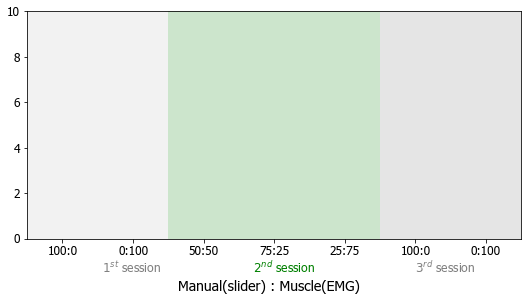

In [37]:
labels = ['100:0','0:100','50:50','75:25','25:75','100:0','0:100'] #slider : EMG
boxcolors = ['white', 'black', 'darkgrey','lightgrey','dimgrey','white', 'black']
datas = [[0],[0],[0],[0],[0],[0],[0]]#[np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
fig,axs = plt.subplots(1, 1,figsize=(7.5,4.5)) 
ax = axs
bplot = ax.boxplot(datas, widths = 0.5,patch_artist=True,labels=labels)
# wrap_labels(ax, 15,labels)

# fill with colors
for patch, color in zip(bplot['boxes'], boxcolors):
    patch.set_facecolor(color)
ax.set_ylim(0,10)
ax.plot([], [], ' ', label=r'Manual(slider) : Muscle(EMG)')
ax.legend(bbox_to_anchor=(0.45, -0.3), loc='lower center',frameon=False,fontsize = 14)
plt.axvspan(0.5,2.5, facecolor='grey', alpha=0.1)
plt.axvspan(2.5,5.5, facecolor='green', alpha=0.2)
plt.axvspan(5.5,7.5, facecolor='grey', alpha=0.2)
plt.text(0.2,0.14, r'$1^{st}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.text(0.48,0.14, r'$2^{nd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'green')
plt.text(0.78,0.14, r'$3^{rd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
plt.tight_layout()
plt.show()

# Plots - comparing conditions

In [40]:
MSEtvalues,MSEtvalues5 = MSETIME(last_trial)
MSEfvalues,MSEfvalues5= MSEFREQ(last_trial,first_freq)
TYRvalues = TYR_NORM(last_trial,first_freq)
TYMDvalues = TYMD_NORM(last_trial,first_freq)

Deltavalues = [] # 7 conditions x (15participants * i/2 trials)
for c in range(num_cond):
    values_ = []
    for p in range(participants_num):
        delta = avgdelta['avgdelta_mag']['subject'+str(p)]['condition'+str(c)].copy()
        delta[0] = 0
        values_.append(LA.norm(delta)) #average of all trials of a participant of a condition
    Deltavalues.append(values_) #each participant 

Deltavalues_below = [] # 7 conditions x (15participants * i/2 trials)
for c in range(num_cond):
    values_ = []
    for p in range(participants_num):
        delta = avgdelta['avgdelta_mag']['subject'+str(p)]['condition'+str(c)][:10].copy()
        delta[0] = 0
        values_.append(LA.norm(delta)) #average of all trials of a participant of a condition
    Deltavalues_below.append(values_) #each participant 

In [41]:
UXvalues = [] # 7 conditions x (15participants * i/2 trials)
for c in range(num_cond):
    values_ = []
    for p in range(participants_num):
        U_less1 = np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['UX'][-last_trial[c]:])
        values_.append( np.mean((LA.norm(U_less1,axis =1))**2) ) #norm of each trial, then take the average for all trials
    UXvalues.append(values_)

In [42]:
# swap position of 0.25 and 0.5 conditions (i.e. condition 2&3)
MSEtvalues[2],MSEtvalues[3] = MSEtvalues[3],MSEtvalues[2]
TYRvalues[2],TYRvalues[3] = TYRvalues[3],TYRvalues[2]
TYMDvalues[2],TYMDvalues[3] = TYMDvalues[3],TYMDvalues[2]
Deltavalues[2],Deltavalues[3] = Deltavalues[3],Deltavalues[2]
UXvalues[2],UXvalues[3] = UXvalues[3],UXvalues[2]


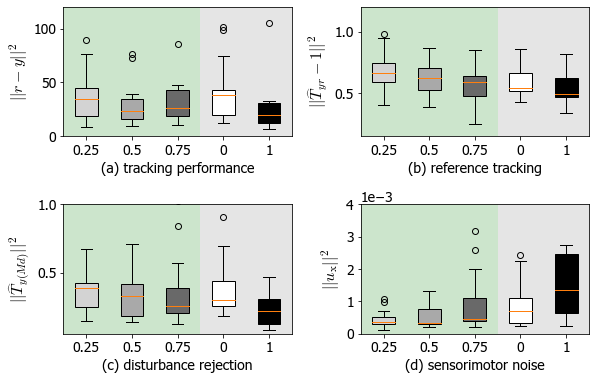

In [107]:
rcParams['mathtext.fontset'] = 'cm'
labels = ['0.25','0.5','0.75','0','1'] #slider : EMG
boxcolors = ['lightgrey','darkgrey','dimgrey','white', 'black']
datas = [MSEtvalues[2:8],TYRvalues[2:8],TYMDvalues[2:8],UXvalues[2:8]]
titles = [r'$||r-y||^2$',r'$||\widehat{T}_{yr}-1||^2$',r'$||\widehat{T}_{y(Md)}||^2$',r'$||u_{\mathrm{x}}||^2$']
ylimits = [(0,120),(0.15,1.2),(0.05,1.0),(0,0.004)] 
yticks0 = [0.,50,100,150]
yticklabels0 = ['0','50','100','150']
yticks = [0.,0.5,1.0,1.5]
yticklabels = ['0.0','0.5','1.0','1.5']
xlabels = ['(a) tracking performance','(b) reference tracking','(c) disturbance rejection','(d) sensorimotor noise']

fig,axs = plt.subplots(2,2,figsize=(8.5,5.5)) #,figsize=(5,4)
ax_all = [axs[0,0],axs[0,1],axs[1,0],axs[1,1]]
for j in range(4):
    ax = ax_all[j]
    bplot = ax.boxplot(datas[j], widths = 0.5,patch_artist=True,labels=labels)
    # wrap_labels(ax, 15,labels)
    if j ==0:
        ax.set_yticks(yticks0)
        ax.set_yticklabels(yticklabels0)
    # elif j == 1:
    #     ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,4))
    elif j == 3:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,4))       
    else:
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)

    for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
        patch.set_facecolor(color)
    ax.set_xlabel(xlabels[j])
    ax.set_ylabel(titles[j],fontsize = 16)
    if ylimits[j] is not None:
        ax.set_ylim(ylimits[j])
    face0 = ax.axvspan(0.5,3.5, facecolor='green', alpha=0.2)
    face1 = ax.axvspan(3.5,5.5, facecolor='grey', alpha=0.2)

#legends
# fig.legend([face0,face1],[r'$2^{nd}$ session',r'$3^{rd}$ session'],
#             bbox_to_anchor=(1.25, 0.4), ncol = 1,frameon=False,fontsize = 14)
# fig.legend(bbox_to_anchor=(0.8, 0.3), loc='lower center',frameon=False,fontsize = 14)
# rcParams['mathtext.fontset'] = 'dejavusans'

# fig.legend([face0,face1,bplot["boxes"][0],bplot["boxes"][1],bplot["boxes"][2],bplot["boxes"][3],bplot["boxes"][4]], 
#             [r'$2^{nd}$ session',r'$3^{rd}$ session',r'$\alpha$ = 0.25',r'$\alpha$ = 0.5',r'$\alpha$ = 0.75',r'$\alpha$ = 0',r'$\alpha$ = 1'] ,
#             bbox_to_anchor=(1.25, 0.75),ncol=1,frameon=False)

plt.tight_layout()
fig = plt.gcf()
fig.savefig('CPHS fig 3.svg')
plt.show()


## old

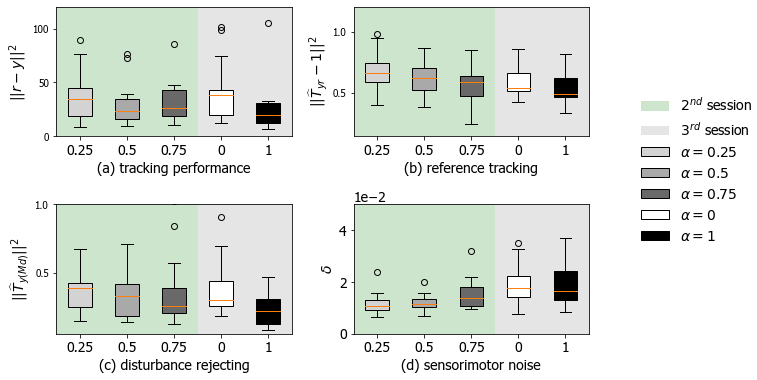

In [73]:
rcParams['mathtext.fontset'] = 'dejavusans'
labels = ['0.25','0.5','0.75','0','1'] #slider : EMG
boxcolors = ['lightgrey','darkgrey','dimgrey','white', 'black']
datas = [MSEtvalues[2:8],TYRvalues[2:8],TYMDvalues[2:8],Deltavalues[2:8]]
titles = [r'$||r-y||^2$',r'$||\widehat{T}_{yr}-1||^2$',r'$||\widehat{T}_{y(Md)}||^2$',r'$\delta$']
ylimits = [(0,120),(0.15,1.2),(0.05,1.0),(0,0.05)] 
yticks0 = [0.,50,100,150]
yticklabels0 = ['0','50','100','150']
yticks = [0.,0.5,1.0,1.5]
yticklabels = ['0.0','0.5','1.0','1.5']
xlabels = ['(a) tracking performance','(b) reference tracking','(c) disturbance rejecting','(d) sensorimotor noise']

fig,axs = plt.subplots(2,2,figsize=(8.5,5.5)) #,figsize=(5,4)
ax_all = [axs[0,0],axs[0,1],axs[1,0],axs[1,1]]
for j in range(4):
    ax = ax_all[j]
    bplot = ax.boxplot(datas[j], widths = 0.5,patch_artist=True,labels=labels)
    # wrap_labels(ax, 15,labels)
    if j ==0:
        ax.set_yticks(yticks0)
        ax.set_yticklabels(yticklabels0, Fontsize=10)
    # elif j == 1:
    #     ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,4))
    elif j == 3:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,4))       
    else:
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels, Fontsize=10)

    for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
        patch.set_facecolor(color)
    ax.set_xlabel(xlabels[j],fontsize = 14)
    ax.set_ylabel(titles[j],fontsize = 14)
    if ylimits[j] is not None:
        ax.set_ylim(ylimits[j])
    face0 = ax.axvspan(0.5,3.5, facecolor='green', alpha=0.2)
    face1 = ax.axvspan(3.5,5.5, facecolor='grey', alpha=0.2)

#legends
# fig.legend([face0,face1],[r'$2^{nd}$ session',r'$3^{rd}$ session'],
#             bbox_to_anchor=(1.25, 0.4), ncol = 1,frameon=False,fontsize = 14)
# fig.legend(bbox_to_anchor=(0.8, 0.3), loc='lower center',frameon=False,fontsize = 14)
fig.legend([face0,face1,bplot["boxes"][0],bplot["boxes"][1],bplot["boxes"][2],bplot["boxes"][3],bplot["boxes"][4]], 
            [r'$2^{nd}$ session',r'$3^{rd}$ session',r'$\alpha=0.25$',r'$\alpha=0.5$',r'$\alpha=0.75$',r'$\alpha=0$',r'$\alpha=1$'] ,
            bbox_to_anchor=(1.25, 0.75),ncol=1,frameon=False,fontsize = 14)

plt.tight_layout()
fig = plt.gcf()
fig.savefig('CPHS fig 3 legend.svg')
plt.show()


## old

C:\Users\hachou\AppData\Local\Temp/ipykernel_4180/2445386537.py:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_yticklabels(yticklabels0, Fontsize=10)
C:\Users\hachou\AppData\Local\Temp/ipykernel_4180/2445386537.py:27: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_yticklabels(yticklabels, Fontsize=10)
C:\Users\hachou\AppData\Local\Temp/ipykernel_4180/2445386537.py:27: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_yticklabels(yticklabels, Fontsize=10)


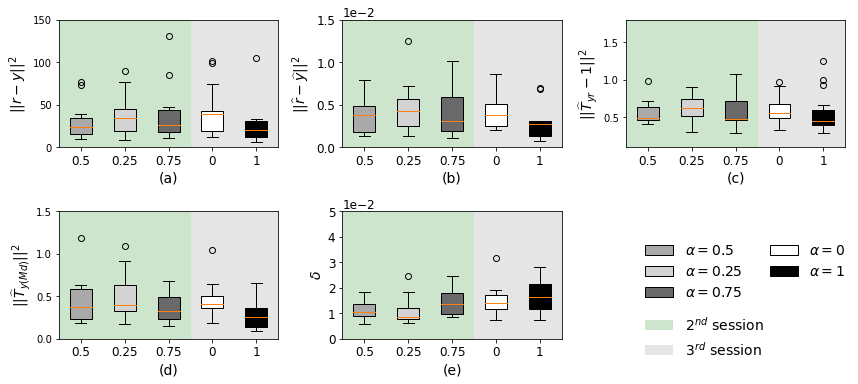

In [28]:
labels = ['0.5','0.25','0.75','0','1'] #slider : EMG
boxcolors = ['darkgrey','lightgrey','dimgrey','white', 'black']
datas = [MSEtvalues[2:8],MSEfvalues[2:8],TYRvalues[2:8],TYMDvalues[2:8],Deltavalues[2:8]]
titles = [r'$||r-y||^2$',r'$||\widehat{r}-\widehat{y}||^2$',r'$||\widehat{T}_{yr}-1||^2$',r'$||\widehat{T}_{y(Md)}||^2$',r'$\delta$']
ylimits = [(0,150),(0,0.015),(0.1,1.8),(0,1.5),(0,0.05)]
yticks0 = [0.,50,100,150]
yticklabels0 = ['0','50','100','150']
yticks = [0.,0.5,1.0,1.5]
yticklabels = ['0.0','0.5','1.0','1.5']
xlabels = ['(a)','(b)','(c)','(d)','(e)',]

fig,axs = plt.subplots(2,3,figsize=(12,5.5)) #,figsize=(5,4)
ax_all = [axs[0,0],axs[0,1],axs[0,2],axs[1,0],axs[1,1]]
for j in range(5):
    ax = ax_all[j]
    bplot = ax.boxplot(datas[j], widths = 0.5,patch_artist=True,labels=labels)
    # wrap_labels(ax, 15,labels)
    if j ==0:
        ax.set_yticks(yticks0)
        ax.set_yticklabels(yticklabels0, Fontsize=10)
    elif j == 1:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,4))
    elif j == 4:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,4))       
    else:
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels, Fontsize=10)

    for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
        patch.set_facecolor(color)
    ax.set_xlabel(xlabels[j],fontsize = 14)
    ax.set_ylabel(titles[j],fontsize = 14)
    if ylimits[j] is not None:
        ax.set_ylim(ylimits[j])
    face0 = ax.axvspan(0.5,3.5, facecolor='green', alpha=0.2)
    face1 = ax.axvspan(3.5,5.5, facecolor='grey', alpha=0.2)

ax = axs[1,2]
ax.set_visible(False)
# text0 = ax.plot([], [], ' ', label=r'Manual(slider) : Muscle(EMG)')

#legends
fig.legend([face0,face1],[r'$2^{nd}$ session',r'$3^{rd}$ session'],
            bbox_to_anchor=(0.905, 0.22), ncol = 1,frameon=False,fontsize = 14)
# fig.legend(bbox_to_anchor=(0.8, 0.3), loc='lower center',frameon=False,fontsize = 14)
fig.legend([bplot["boxes"][0],bplot["boxes"][1],bplot["boxes"][2],bplot["boxes"][3],bplot["boxes"][4]], 
            [r'$\alpha=0.5$',r'$\alpha=0.25$',r'$\alpha=0.75$',r'$\alpha=0$',r'$\alpha=1$'] ,
            bbox_to_anchor=(1, 0.4),ncol=2,frameon=False,fontsize = 14)

# ax = axs[0,0]
# # statistical annotation
# x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
# y, h, col = np.max(datas[0]) + 2, 2, 'k'
# ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
# ax.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

plt.tight_layout()
plt.show()


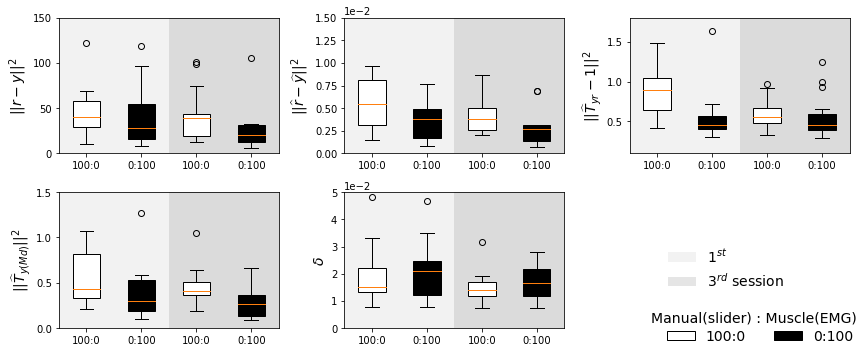

In [331]:
labels = ['100:0','0:100','100:0','0:100'] #slider : EMG
boxcolors = ['white', 'black','white', 'black']
datas = [np.concatenate([MSEtvalues[:2],MSEtvalues[-2:]]).tolist(),
        np.concatenate([MSEfvalues[:2],MSEfvalues[-2:]]).tolist(),
        np.concatenate([TYRvalues[:2],TYRvalues[-2:]]).tolist(),
        np.concatenate([TYMDvalues[:2],TYMDvalues[-2:]]).tolist(),
        np.concatenate([Deltavalues[:2],Deltavalues[-2:]]).tolist()]
titles = [r'$||r-y||^2$',r'$||\widehat{r}-\widehat{y}||^2$',r'$||\widehat{T}_{yr}-1||^2$',r'$||\widehat{T}_{y(Md)}||^2$',r'$\delta$']
ylimits = [(0,150),(0,0.015),(0.1,1.8),(0,1.5),(0,0.05)]
labels = ['100:0','0:100','100:0','0:100'] #slider : EMG
yticks0 = [0.,50,100,150]
yticklabels0 = ['0','50','100','150']
yticks = [0.,0.5,1.0,1.5]
yticklabels = ['0.0','0.5','1.0','1.5']

fig,axs = plt.subplots(2,3,figsize=(12,5)) #,figsize=(5,4)
ax_all = [axs[0,0],axs[0,1],axs[0,2],axs[1,0],axs[1,1]]
for j in range(5):
    ax = ax_all[j]
    bplot = ax.boxplot(datas[j], widths = 0.5,patch_artist=True,labels=labels)
    # wrap_labels(ax, 15,labels)
    if j ==0:
        ax.set_yticks(yticks0)
        ax.set_yticklabels(yticklabels0, Fontsize=10)
    elif j == 1:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,4))
    elif j == 4:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,4))       
    else:
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels, Fontsize=10)

    for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
        patch.set_facecolor(color)
    ax.set_ylabel(titles[j],fontsize = 14)
    if ylimits[j] is not None:
        ax.set_ylim(ylimits[j])
    face0 = ax.axvspan(0.5,4.5, facecolor='grey', alpha=0.1)
    face1 = ax.axvspan(2.5,4.5, facecolor='grey', alpha=0.2)

ax = axs[1,2]
ax.set_visible(False)
text0 = ax.plot([], [], ' ', label=r'Manual(slider) : Muscle(EMG)')

#legends
fig.legend([face0,face1],[r'$1^{st}$',r'$3^{rd}$ session'],
            bbox_to_anchor=(0.84, 0.15), loc='lower center',ncol = 1,frameon=False,fontsize = 14)
fig.legend(bbox_to_anchor=(0.85, 0.05), loc='lower center',frameon=False,fontsize = 14)
fig.legend([bplot["boxes"][0],bplot["boxes"][1]], ['100:0','0:100'],
            loc='lower right',ncol=2,frameon=False,fontsize = 14)

plt.tight_layout()
plt.show()

## (old) compare sessions

<ipython-input-252-8e110075ed55>:69: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


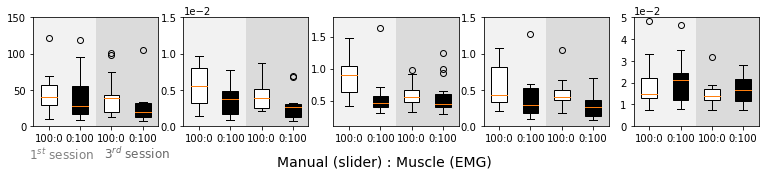

In [252]:
fig,axs = plt.subplots(1,5,figsize=(13,2)) #,figsize=(5,4)

# top row
ax_all = [axs[0],axs[1],axs[2],axs[3],axs[4]]
labels = ['100:0','0:100','100:0','0:100'] #slider : EMG
boxcolors = ['white', 'black','white', 'black']
# datas = [MSEtvalues[:2],,MSEfvalues[2:8],TYRvalues[2:8],TUDvalues[2:8],Deltavalues[2:8]]
datas = [np.concatenate([MSEtvalues[:2],MSEtvalues[-2:]]).tolist(),
        (np.concatenate([MSEfvalues[:2],MSEfvalues[-2:]])).tolist(),
        np.concatenate([TYRvalues[:2],TYRvalues[-2:]]).tolist(),
        np.concatenate([TYMDvalues[:2],TYMDvalues[-2:]]).tolist(),
        np.concatenate([Deltavalues[:2],Deltavalues[-2:]]).tolist()]
titles = [r'$||r-y||^2$',r'$||\widehat{r}-\widehat{y}||^2$',r'$||\widehat{T}_{yr}-1||^2$',r'$||\widehat{T}_{y(Md)}||^2$',r'$\delta = (1+BM)u$']
ylimits = [(0,150),(0,0.015),(0.1,1.8),(0,1.5),(0,0.05)]
labels = ['100:0','0:100','100:0','0:100'] #slider : EMG
yticks0 = [0.,50,100,150]
yticklabels0 = ['0','50','100','150']
yticks = [0.,0.5,1.0,1.5]
yticklabels = ['0.0','0.5','1.0','1.5']

for j in range(5):
    ax = ax_all[j]
    bplot = ax.boxplot(datas[j], widths = 0.5,patch_artist=True,labels=labels)
    ax.set_xticklabels(labels=labels, Fontsize=10) #rotation = 45, 
 
    if j ==0:
        ax.set_yticks(yticks0)
        ax.set_yticklabels(yticklabels0, Fontsize=10)
    elif j == 1:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,4))
    elif j == 4:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,4))       
    else:
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels, Fontsize=10)
        
    # wrap_labels(ax, 15,labels)
    # ax.set_xticklabels(labels, rotation=45)
    for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
        patch.set_facecolor(color)
    # ax.set_ylabel(titles[j],fontsize = 14)
    if ylimits[j] is not None:
        ax.set_ylim(ylimits[j])
    ax.axvspan(0.5,4.5, facecolor='grey', alpha=0.1)
    ax.axvspan(2.5,4.5, facecolor='grey', alpha=0.2)

# ax = axs[1,0]
# ax.text(0.15,0.04, r'$2^{nd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'green')
# ax.text(0.35,0.04, r'$3^{rd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
# ax = axs[1,1]
# ax.text(0.6,0.04, r'$2^{nd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'green')
# ax.text(0.8,0.04, r'$3^{rd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')

# axs[2,0].set_position([0.5,0.5,])
# fig.text(0.5, 1,r'$1^{st}$ session vs. $3^{rd}$ session', ha='center',fontsize = 14)
# fig.suptitle(0.5, 1,r'$1^{st}$ session vs. $3^{rd}$ session')
# fig.supxlabel(r'Manual(slider) : Muscle(EMG)')
ax.text(0.12,-0.1, r'$1^{st}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
ax.text(0.2,-0.1, r'$3^{rd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'dimgrey')
fig.text(0.5, -0.15,r'Manual (slider) : Muscle (EMG)', ha='center',fontsize = 14)
# plt.plot([], [], ' ', label=r'Manual(slider) : Muscle(EMG)')
# plt.legend(bbox_to_anchor=(0.25, 0.25), loc='lower center',frameon=False,fontsize = 14)
plt.tight_layout()
plt.show()

In [ ]:
#bottom row
ax_all = [axs[1,0],axs[1,1],axs[1,2],axs[1,3]]
labels = ['50:50','75:25','25:75','100:0','0:100'] #slider : EMG
boxcolors = ['darkgrey','lightgrey','dimgrey','white', 'black']
datas = [MSEtvalues[2:8],MSEfvalues[2:8],TYRvalues[2:8],TYMDvalues[2:8]] 
titles = [r'$||r-y||^2$',r'$||\widehat{r}-\widehat{y}||^2$',r'$||\widehat{T}_{yr}-1||^2$',r'$||\widehat{T}_{y(Md)}||^2$']
ylimits = [(0,125),(0,0.012),(0.1,1.5),(0,1.5)]

for j in range(4):
    ax = ax_all[j]
    bplot = ax.boxplot(datas[j], widths = 0.5,patch_artist=True,labels=labels)
    ax.set_xticklabels(labels=labels, Fontsize=10) #rotation = 45,
    # wrap_labels(ax, 15,labels)
    # ax.set_xticklabels(labels, rotation=45)
    for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
        patch.set_facecolor(color)
    # ax.set_ylabel(titles[j],fontsize = 14)
    if ylimits[j] is not None:
        ax.set_ylim(ylimits[j])
    ax.axvspan(0.5,3.5, facecolor='green', alpha=0.2)
    ax.axvspan(3.5,5.5, facecolor='grey', alpha=0.2)

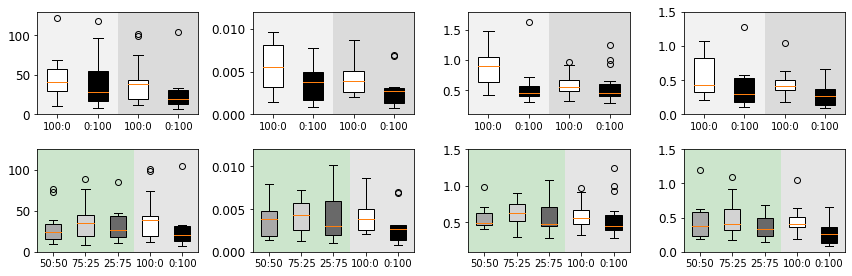

In [196]:
fig,axs = plt.subplots(2,4,figsize=(12,4)) #,figsize=(5,4)

# top row
ax_all = [axs[0,0],axs[0,1],axs[0,2],axs[0,3]]
labels = ['100:0','0:100','100:0','0:100'] #slider : EMG
boxcolors = ['white', 'black','white', 'black']
# datas = [MSEtvalues[:2],,MSEfvalues[2:8],TYRvalues[2:8],TUDvalues[2:8],Deltavalues[2:8]]
datas = [np.concatenate([MSEtvalues[:2],MSEtvalues[-2:]]).tolist(),
        np.concatenate([MSEfvalues[:2],MSEfvalues[-2:]]).tolist(),
        np.concatenate([TYRvalues[:2],TYRvalues[-2:]]).tolist(),
        np.concatenate([TYMDvalues[:2],TYMDvalues[-2:]]).tolist(),
        np.concatenate([Deltavalues[:2],Deltavalues[-2:]]).tolist()]
titles = [r'$||r-y||^2$',r'$||\widehat{r}-\widehat{y}||^2$',r'$||\widehat{T}_{yr}-1||^2$',r'$||\widehat{T}_{y(Md)}||^2$',r'$\delta = (1+BM)u$']
ylimits = [(0,130),(0,0.012),(0.1,1.8),(0,1.5),(0,0.05)]

for j in range(4):
    ax = ax_all[j]
    bplot = ax.boxplot(datas[j], widths = 0.5,patch_artist=True,labels=labels)
    ax.set_xticklabels(labels=labels, Fontsize=10) #rotation = 45, 
    # wrap_labels(ax, 15,labels)
    # ax.set_xticklabels(labels, rotation=45)
    for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
        patch.set_facecolor(color)
    # ax.set_ylabel(titles[j],fontsize = 14)
    if ylimits[j] is not None:
        ax.set_ylim(ylimits[j])
    ax.axvspan(0.5,4.5, facecolor='grey', alpha=0.1)
    ax.axvspan(2.5,4.5, facecolor='grey', alpha=0.2)
# ax.text(0.15,0.06, r'$1^{st}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
# ax.text(0.33,0.06, r'$3^{rd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')

#bottom row
ax_all = [axs[1,0],axs[1,1],axs[1,2],axs[1,3]]
labels = ['50:50','75:25','25:75','100:0','0:100'] #slider : EMG
boxcolors = ['darkgrey','lightgrey','dimgrey','white', 'black']
datas = [MSEtvalues[2:8],MSEfvalues[2:8],TYRvalues[2:8],TYMDvalues[2:8]] 
titles = [r'$||r-y||^2$',r'$||\widehat{r}-\widehat{y}||^2$',r'$||\widehat{T}_{yr}-1||^2$',r'$||\widehat{T}_{y(Md)}||^2$']
ylimits = [(0,125),(0,0.012),(0.1,1.5),(0,1.5)]

for j in range(4):
    ax = ax_all[j]
    bplot = ax.boxplot(datas[j], widths = 0.5,patch_artist=True,labels=labels)
    ax.set_xticklabels(labels=labels, Fontsize=10) #rotation = 45,
    # wrap_labels(ax, 15,labels)
    # ax.set_xticklabels(labels, rotation=45)
    for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
        patch.set_facecolor(color)
    # ax.set_ylabel(titles[j],fontsize = 14)
    if ylimits[j] is not None:
        ax.set_ylim(ylimits[j])
    ax.axvspan(0.5,3.5, facecolor='green', alpha=0.2)
    ax.axvspan(3.5,5.5, facecolor='grey', alpha=0.2)

ax = axs[1,0]
# ax.text(0.15,0.04, r'$2^{nd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'green')
# ax.text(0.35,0.04, r'$3^{rd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
# ax = axs[1,1]
# ax.text(0.6,0.04, r'$2^{nd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'green')
# ax.text(0.8,0.04, r'$3^{rd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')

# axs[2,0].set_position([0.5,0.5,])
# plt.plot([], [], ' ', label=r'Manual(slider) : Muscle(EMG)')
# plt.legend(bbox_to_anchor=(0.25, 0.25), loc='lower center',frameon=False,fontsize = 14)
plt.tight_layout()
plt.show()

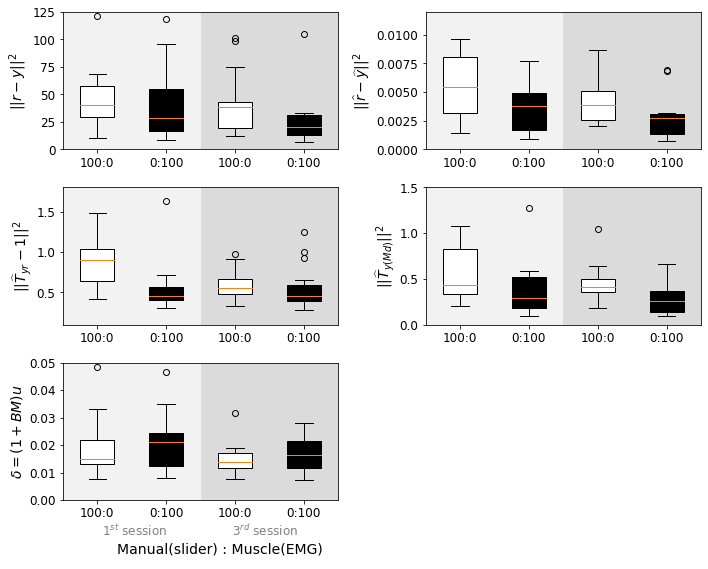

In [170]:
labels = ['100:0','0:100','100:0','0:100'] #slider : EMG
boxcolors = ['white', 'black','white', 'black']
# datas = [MSEtvalues[:2],,MSEfvalues[2:8],TYRvalues[2:8],TUDvalues[2:8],Deltavalues[2:8]]
datas = [np.concatenate([MSEtvalues[:2],MSEtvalues[-2:]]).tolist(),
        np.concatenate([MSEfvalues[:2],MSEfvalues[-2:]]).tolist(),
        np.concatenate([TYRvalues[:2],TYRvalues[-2:]]).tolist(),
        np.concatenate([TYMDvalues[:2],TYMDvalues[-2:]]).tolist(),
        np.concatenate([Deltavalues[:2],Deltavalues[-2:]]).tolist()]
titles = [r'$||r-y||^2$',r'$||\widehat{r}-\widehat{y}||^2$',r'$||\widehat{T}_{yr}-1||^2$',r'$||\widehat{T}_{y(Md)}||^2$',r'$\delta = (1+BM)u$']
ylimits = [(0,125),(0,0.012),(0.1,1.8),(0,1.5),(0,0.05)]


fig,axs = plt.subplots(3,2,figsize=(10,8)) #,figsize=(5,4)
ax_all = [axs[0,0],axs[0,1],axs[1,0],axs[1,1],axs[2,0]]
for j in range(5):
    ax = ax_all[j]
    bplot = ax.boxplot(datas[j], widths = 0.5,patch_artist=True,labels=labels)
    wrap_labels(ax, 15,labels)
    # ax.set_xticklabels(labels, rotation=45)
    for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
        patch.set_facecolor(color)
    ax.set_ylabel(titles[j],fontsize = 14)
    if ylimits[j] is not None:
        ax.set_ylim(ylimits[j])
    ax.axvspan(0.5,4.5, facecolor='grey', alpha=0.1)
    ax.axvspan(2.5,4.5, facecolor='grey', alpha=0.2)
ax.text(0.15,0.06, r'$1^{st}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')
ax.text(0.33,0.06, r'$3^{rd}$ session', fontsize=12, transform=plt.gcf().transFigure,color = 'grey')

axs[2,1].set_visible(False)
# axs[2,0].set_position([0.5,0.5,])
ax.plot([], [], ' ', label=r'Manual(slider) : Muscle(EMG)')
ax.legend(bbox_to_anchor=(0.5, -0.5), loc='lower center',frameon=False,fontsize = 14)
plt.tight_layout()
plt.show()

# Plots - stimuli

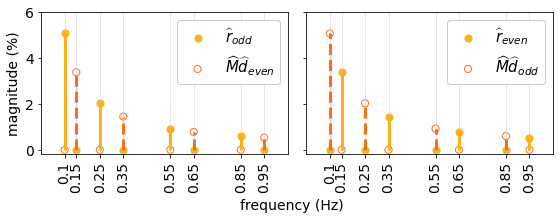

In [13]:
# plt.figure(figsize=(8, 2))
p = 10 #subject number
c = 2 #condition number

font = {#'family' : 'normal',
        # 'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)

fig,axs = plt.subplots(1, 2,sharex = True,sharey = True,figsize=(8, 3)) 

xticks = prime*0.05
xticklabels =np.round(prime*0.05,2)

ax = axs[0]
i = 13 #trial number
ax.vlines(xf[stimulated_index],ymin=-0.3, ymax=10,linewidth=1, color='0.8',alpha = 0.5)
R = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R'][i][:N//2] )
MD = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['MD'][i][:N//2] )
ax.scatter(xf[stimulated_index],100*R[stimulated_index], color=colors['r'],label=r'$\widehat{r}_{odd}$',s=50)
ax.scatter(xf[stimulated_index],100*MD[stimulated_index], color=colors['d'],label=r'$\widehat{M}\widehat{d}_{even}$',facecolors='none',s=50)
ax.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*R[stimulated_index],color=colors['r'],linewidth = 3)
ax.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*MD[stimulated_index],linestyles='--',color=colors['d'],linewidth = 3)
ax.set_xlim((0,21*base_freq))
ax.set_ylim((-0.2,6))
# ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('magnitude (%)')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=90)
# ax.legend( loc='upper right', ncol=2, frameon=True)
ax.legend( loc='upper right', ncol=1, frameon=True, prop={'size': 15},facecolor = 'white',framealpha = 1)


ax = axs[1]
i = 12 #trial number
ax.vlines(xf[stimulated_index],ymin=-0.3, ymax=10,linewidth=1, color='0.8',alpha = 0.5)
R = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R'][i][:N//2] )
MD = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['MD'][i][:N//2] )
ax.scatter(xf[stimulated_index],100*R[stimulated_index], color=colors['r'],label=r'$\widehat{r}_{even}$',s=50)
ax.scatter(xf[stimulated_index],100*MD[stimulated_index], color=colors['d'],label=r'$\widehat{M}\widehat{d}_{odd}$',facecolors='none',s=50)
ax.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*R[stimulated_index],color=colors['r'],linewidth = 3)
ax.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*MD[stimulated_index],linestyles='--',color=colors['d'],linewidth = 3)
ax.set_xlim((0,21*base_freq))
ax.set_ylim((-0.2,6))
# ax.set_xlabel('frequency (Hz)')
# ax.set_ylabel('magnitude (%)')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=90)
ax.legend( loc='upper right', ncol=1, frameon=True, prop={'size': 15},facecolor = 'white',framealpha = 1)
fig.text(0.52, -0.01, 'frequency (Hz)', ha='center',wrap=True)

plt.tight_layout()
plt.show()

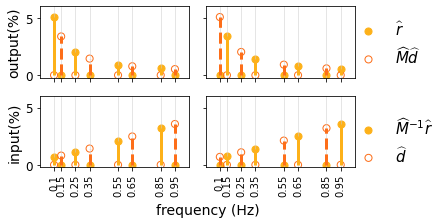

In [14]:
# plt.figure(figsize=(8, 2))
p = 10 #subject number
c = 2 #condition number

font = {#'family' : 'normal',
        # 'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

fig,axs = plt.subplots(2, 2,sharex = True,sharey = True,figsize=(6.5, 3)) 

xticks = prime*0.05
xticklabels =np.round(prime*0.05,2)

for j in [0,1]:
    if j == 0:
        i = 13 #trial number, #OE trials = [1,3,5 ...] (ref-dis-ref...)
        # labels = [r'$\widehat{r}_{odd}$',r'$\widehat{M}\widehat{d}_{even}$',r'$\widehat{M}^{-1}\widehat{r}_{odd}$',r'$\widehat{d}_{even}$']
        labels = [r'$\widehat{r}$',r'$\widehat{M}\widehat{d}$',r'$\widehat{M}^{-1}\widehat{r}$',r'$\widehat{d}$']
    else:
        i = 12 #trial number,  #EO trials = [0,2,4 ...] (dis-ref-dis ...)
        # labels = [r'$\widehat{r}_{even}$',r'$\widehat{M}\widehat{d}_{odd}$',r'$\widehat{M}^{-1}\widehat{r}_{even}$',r'$\widehat{d}_{odd}$']
        labels = [r'$\widehat{r}$',r'$\widehat{M}\widehat{d}$',r'$\widehat{M}^{-1}\widehat{r}$',r'$\widehat{d}$']

    ax = axs[0,j]
    ax.vlines(xf[stimulated_index],ymin=-0.3, ymax=10,linewidth=1, color='0.8',alpha = 0.5)
    R = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R'][i][:N//2] )
    MD = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['MD'][i][:N//2] )
    ax.scatter(xf[stimulated_index],100*R[stimulated_index], color=colors['r'],label=labels[0],s=50)
    ax.scatter(xf[stimulated_index],100*MD[stimulated_index], color=colors['d'],label=labels[1],facecolors='none',s=50)
    ax.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*R[stimulated_index],color=colors['r'],linewidth = 3)
    ax.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*MD[stimulated_index],linestyles='--',color=colors['d'],linewidth = 3)
    ax.set_xlim((0,21*base_freq))
    ax.set_ylim((-0.2,6))
    ax.set_xticks(xticks)
    # ax.set_xticklabels(xticklabels,rotation=90)
    # ax.legend( loc='upper right', ncol=2, frameon=False, prop={'size': 15},facecolor = 'white',framealpha = 1,columnspacing = 0.1)

    ax = axs[1,j]
    ax.vlines(xf[stimulated_index],ymin=-0.3, ymax=10,linewidth=1, color='0.8',alpha = 0.5)
    WR = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['WR'][i][:N//2] )
    D = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['D'][i][:N//2] )
    ax.scatter(xf[stimulated_index],100*WR[stimulated_index], color=colors['r'],label=labels[2],s=50)
    ax.scatter(xf[stimulated_index],100*D[stimulated_index], color=colors['d'],label=labels[3],facecolors='none',s=50)
    ax.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*WR[stimulated_index],color=colors['r'],linewidth = 3)
    ax.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*D[stimulated_index],linestyles='--',color=colors['d'],linewidth = 3)
    ax.set_xlim((0,21*base_freq))
    ax.set_ylim((-0.2,6))
    # ax.set_xlabel('frequency (Hz)')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels,rotation=90,fontsize = 10)
    # ax.legend( loc='upper left', ncol=2, frameon=False, prop={'size': 15},facecolor = 'white',framealpha = 1,columnspacing = 0.1)

axs[0,1].legend( bbox_to_anchor=(0.9, 1), ncol=1, frameon=False, prop={'size': 15},facecolor = 'white',framealpha = 1,columnspacing = 0.1)
axs[1,1].legend( bbox_to_anchor=(0.9, 0.9), ncol=1, frameon=False, prop={'size': 15},facecolor = 'white',framealpha = 1,columnspacing = 0.1)
longaxis = textwrap.fill('output(%)', width=12)
axs[0,0].set_ylabel(longaxis , fontsize=14)
longaxis = textwrap.fill('input(%)', width=12)
axs[1,0].set_ylabel(longaxis , fontsize=14)
fig.text(0.48, -0.02, 'frequency (Hz)', ha='center',wrap=True, fontsize=14)
plt.tight_layout()
plt.show()

# Plots - user inputs at non-stimuli & stimuli

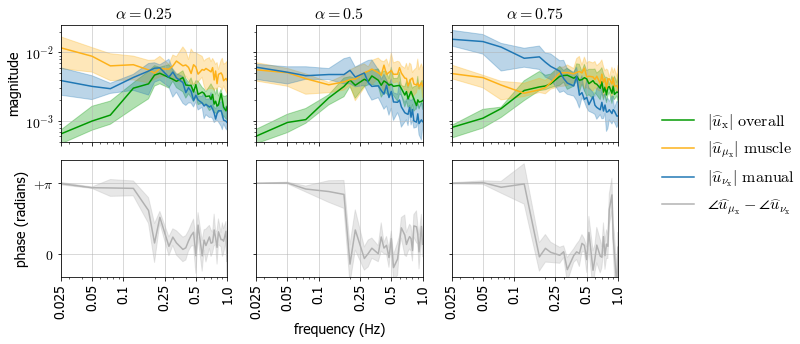

In [106]:
#mask for index of freq that are less than 1Hz
def lessthanone(x): return x <= 1.0
indexone = [idx for idx, element in enumerate(xf) if lessthanone(element)]
unwanted_index = {4, 6, 10, 14, 22, 26, 34, 38}
nonstimulated_index = [i for i in indexone if i not in unwanted_index]

rcParams['font.family'] = 'sans-serif'
rcParams['mathtext.fontset'] = 'cm'

#replot for presentations
fig,axs = plt.subplots(2, 3, sharex = 'col', sharey = 'row',figsize=(9,5))
j = 0
for c in [3,2,4]: #conditions
    # mag plots
    xlim = (0.025, 1.0)
    xticks = np.array([.025,.05,.1,.25,.5,1.])
    ylim = (0.5*1e-3,0.25*1e-1)
    yticks = [1e-2,1e-3]
    ytickslabels = [r'$10^{-2}$',r'$10^{-3}$']
    ylimphase = (-1,np.pi+1)
    yticksphase = [0.,np.pi]
    yticklabelsphase = [r'$0$',r'$+\pi$']
    Colors = [colors['u'],colors['r'],colors['BLUE']]
    FillColors = [ufill,rfill,bfill,gfill]
    Labels = [r'$|\widehat{u}_{\mathrm{x}}|\ \mathrm{overall}$',r'$|\widehat{u}_{\mu_{\mathrm{x}}}|\ \mathrm{muscle}$',r'$|\widehat{u}_{\nu_{\mathrm{x}}}|\ \mathrm{manual}$'] #'ux in slider only','ux in EMG only'

    #mag
    ax = axs[0,j]
    UX_mean = []
    U0X_mean = []
    U1X_mean = []
    UX_sim = np.abs(LQG_SIM['EO']['LQG_U'][nonstimulated_index])
    # add_mean = []

    for p in range(participants_num):
        UX_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['UX'][-last_trial[c]:]) ,axis = 0) ) #avg UX of one participant
        U0X_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0X'][-last_trial[c]:]) ,axis = 0) ) #avg UX of one participant
        U1X_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1X'][-last_trial[c]:]) ,axis = 0) ) #avg UX of one participant
        # add_mean.append( np.mean( np.abs(0.5*np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0X'][-last_trial[c]:]) + 
        #                                  0.5*np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1X'][-last_trial[c]:])) ,axis = 0) ) #avg UX of one participant

    # UX_mean_mean = np.mean( UX_mean, axis = 0) #avg UX of all participants
    # U0X_mean_mean = np.mean( U0X_mean, axis = 0) #avg UX of all participants
    # U1X_mean_mean = np.mean( U1X_mean, axis = 0) #avg UX of all participants
    UX_mean_mean = np.percentile(UX_mean, 50, axis=0)
    U0X_mean_mean = np.percentile(U0X_mean, 50, axis=0)
    U1X_mean_mean = np.percentile(U1X_mean, 50, axis=0)

    UX_mean_25 = np.percentile(UX_mean, 25, axis=0)
    U0X_mean_25 = np.percentile(U0X_mean, 25, axis=0)
    U1X_mean_25 = np.percentile(U1X_mean, 25, axis=0)

    UX_mean_75 = np.percentile(UX_mean, 75, axis=0)
    U0X_mean_75 = np.percentile(U0X_mean, 75, axis=0)
    U1X_mean_75 = np.percentile(U1X_mean, 75, axis=0)

    ax.plot(xf[nonstimulated_index], UX_mean_mean , color=Colors[0])
    ax.plot(xf[nonstimulated_index], U0X_mean_mean , color=Colors[1])
    ax.plot(xf[nonstimulated_index], U1X_mean_mean , color=Colors[2])

    ax.fill_between(xf[nonstimulated_index], UX_mean_25, UX_mean_75,
                        facecolor=FillColors[0],edgecolor=Colors[0],alpha = 0.3)
    ax.fill_between(xf[nonstimulated_index], U0X_mean_25, U0X_mean_75,
                        facecolor=FillColors[1],edgecolor=Colors[1],alpha = 0.3)
    ax.fill_between(xf[nonstimulated_index], U1X_mean_25, U1X_mean_75,
                        facecolor=FillColors[2],edgecolor=Colors[2],alpha = 0.3)

    #plot difference of phases, i.e. complex(u_emg / u_slider)
    ax = axs[1,j]
    diff_phase_mean = []

    for p in range(participants_num):
        diff_phase = []
        for i in range(last_trial[c]):
            diff_phase.append( np.angle(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0X'][-last_trial[c]:][i] / 
                                DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1X'][-last_trial[c]:][i]) )                    
        # diff_phase_mean.append( np.mean(np.abs(diff_phase), axis = 0) ) #avg phase diff of one participant
        diff_phase_mean.append( np.angle( np.mean(np.exp(1j*np.asarray(diff_phase)), axis=0) ) )
        #circular stats

    # diff_phase_mean_mean = np.mean( diff_phase_mean, axis = 0) #avg phase diff of all participants
    # diff_phase_mean_mean = np.mean(np.exp(1j*diff_phase_mean), axis=0)
    # diff_phase_mean_25 = np.percentile(diff_phase_mean, 25, axis=0) 
    # diff_phase_mean_75 = np.percentile(diff_phase_mean, 75, axis=0) 
    z = np.mean(np.exp(1j*(np.asarray(diff_phase_mean)-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1-np.abs(z)

    ax.plot(xf[nonstimulated_index], mean , color=colors['g'],alpha = 1)
    # ax.fill_between(xf[nonstimulated_index], diff_phase_mean_25, diff_phase_mean_75,
    #                     facecolor=FillColors[3],edgecolor=colors['BLUE'],alpha = 0.2)
    ax.fill_between(xf[nonstimulated_index], mean+disp,mean-disp,
                        facecolor=FillColors[3],edgecolor=colors['g'],alpha = 0.3)

    ax = axs[0,j]
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_yscale("log")
    ax.grid('on',zorder=-1,alpha = 0.6)
    
    ax = axs[1,j]
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.set_ylim(ylimphase)
    ax.grid('on',zorder=-1,alpha = 0.6)

    j+=1
ax = axs[0,0]
ax.set_yticks(yticks)
ax.set_yticklabels(ytickslabels)
ax.plot([],[],color=Colors[0], label=Labels[0])
ax.plot([],[],color=Colors[1], label=Labels[1])
ax.plot([],[],color=Colors[2], label=Labels[2])
ax = axs[1,0]
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.plot([],[],color=colors['g'], label=r'$\angle{\widehat{u}_{\mu_{\mathrm{x}}}} - \angle{\widehat{u}_{\nu_{\mathrm{x}}}}$')
axs[0,0].title.set_text(r'$\alpha = 0.25$')
axs[0,1].title.set_text(r'$\alpha = 0.5$')
axs[0,2].title.set_text(r'$\alpha = 0.75$')
axs[1,1].set_xlabel('frequency (Hz)')
axs[0,0].set_ylabel('magnitude') 
axs[1,0].set_ylabel('phase (radians)')

fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',frameon=False,fontsize = 16)
# axs[1,2].legend(bbox_to_anchor=(-0.3, -0.6), loc='center left',frameon=False,fontsize = 14)
# fig.suptitle('Non in condition '+str(c)+'(all participants)')
axs[0,1].get_shared_x_axes().join(axs[0,0], axs[0,1])
plt.tight_layout()

fig = plt.gcf()
fig.savefig('CPHS fig 4.svg')

plt.show()

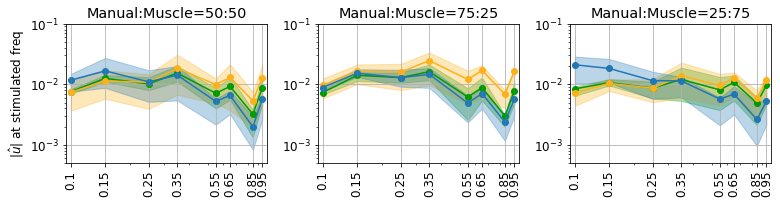

In [16]:
fig,axs = plt.subplots(1, 3,sharex=True,figsize=(11,3))

j=0
Colors = [colors['u'],colors['r'],colors['BLUE']]
for c in [2,3,4]: #conditions
    xlim = (0.095, 1.0)
    xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95]) #prime*0.05
    ylim = (0.5*1e-3,1e-1)
    for ii in prime: # prime multiples of a base frequency (1/20Hz)
        ax.axvline(x = ii*base_freq,linewidth=1, color='0.8',alpha = 0.1)

    #mag
    ax = axs[j]
    U_mean = []
    U0_mean = []
    U1_mean = []
    U_sim = np.abs(LQG_SIM['OE']['LQG_U'][stimulated_index])

    for p in range(participants_num):
        U_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U'][-last_trial[c]:][1::2]) ,axis = 0)[stimulated_index] ) #avg UX of one participant
        U0_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][-last_trial[c]:][1::2]) ,axis = 0)[stimulated_index] ) #avg UX of one participant
        U1_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1'][-last_trial[c]:][1::2]) ,axis = 0)[stimulated_index] ) #avg UX of one participant

    U_mean_mean = np.mean( U_mean, axis = 0) #avg UX of all participants
    U0_mean_mean = np.mean( U0_mean, axis = 0) #avg UX of all participants
    U1_mean_mean = np.mean( U1_mean, axis = 0) #avg UX of all participants

    U_mean_25 = np.percentile(U_mean, 25, axis=0)
    U0_mean_25 = np.percentile(U0_mean, 25, axis=0)
    U1_mean_25 = np.percentile(U1_mean, 25, axis=0)

    U_mean_75 = np.percentile(U_mean, 75, axis=0)
    U0_mean_75 = np.percentile(U0_mean, 75, axis=0)
    U1_mean_75 = np.percentile(U1_mean, 75, axis=0)

    ax.plot(xf[stimulated_index], U_mean_mean, 'o-', color=Colors[0], label=Labels[0])
    ax.plot(xf[stimulated_index], U0_mean_mean,'o-', color=Colors[1], label=Labels[1])
    ax.plot(xf[stimulated_index], U1_mean_mean, 'o-', color=Colors[2], label=Labels[2])

    ax.fill_between(xf[stimulated_index], U_mean_25, U_mean_75,
                        facecolor=FillColors[0],edgecolor=Colors[0],alpha = 0.3)
    ax.fill_between(xf[stimulated_index], U0_mean_25, U0_mean_75,
                        facecolor=FillColors[1],edgecolor=Colors[1],alpha = 0.3)
    ax.fill_between(xf[stimulated_index], U1_mean_25, U1_mean_75,
                        facecolor=FillColors[2],edgecolor=Colors[2],alpha = 0.3)

    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.set_yscale("log")
    ax.grid('on',zorder=-1)

    j+=1

axs[0].title.set_text('Manual:Muscle=50:50')
axs[1].title.set_text('Manual:Muscle=75:25')
axs[2].title.set_text('Manual:Muscle=25:75')
axs[0].set_ylabel(r'$|\hat{u}|$ at stimulated freq') 
plt.tight_layout()
plt.show()

# functions

## time domain tracking error (r-y) 

In [15]:
def MSETIME(last_trial):
    """
    number of trials to look at of each condition: (ex: last 4)
    last_trial = [4,4,8,8,8,4,4]

    what freqs to look at over all 8 stim freqs: (ex: [1,2,3,4,5,6,7,8])
    first_freq = [0,1,2,3,4,5,6,7]
    """

    #(1) MSE time: for every trial for every participant (1 number for each trial)
    MSEt = {}
    for p in range(participants_num): # number of participants = 15
        MSEt['subject'+str(p)] = {}
        for c in range(num_cond):  # number of conditions  = 7
            r = np.asarray(DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][-last_trial[c]:])
            y = np.asarray(DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][-last_trial[c]:])
            MSEt['subject'+str(p)]['condition'+str(c)] = np.sum((r-y)**2,axis=1) #time domain error of each trial of each participant

    MSEtvalues = [] # 7 conditions x (15participants * i trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(MSEt['subject'+str(p)]['condition'+str(c)])) #average TD error of all trials of a participant of a condition
        MSEtvalues.append(values_)

    MSEtvalues5 = [] # 7 conditions x (15participants * i trials)
    for c in range(5):
        values_ = []
        for p in range(participants_num):
            if c==0:
                values_.append(np.mean(np.concatenate([MSEt['subject'+str(p)]['condition'+str(c)],MSEt['subject'+str(p)]['condition'+str(5)]])))
            elif c==1:
                values_.append(np.mean(np.concatenate([MSEt['subject'+str(p)]['condition'+str(c)],MSEt['subject'+str(p)]['condition'+str(6)]])))
            else:
                values_.append(np.mean(MSEt['subject'+str(p)]['condition'+str(c)])) #average TD error of all trials of a participant of a condition
        MSEtvalues5.append(values_)

    return MSEtvalues,MSEtvalues5 #average MSE over all trials for every participant

## freq domain tracking errror

In [16]:
def MSEFREQ(last_trial,first_freq):
    """
    number of trials to look at of each condition: (ex: last 4)
    last_trial = [4,4,8,8,8,4,4]

    what freqs to look at over all 8 stim freqs: (ex: [1,2,3,4,5,6,7,8])
    first_freq = [0,1,2,3,4,5,6,7]
    """
    #(2) MSE freq: for every two trial for every participant (1 number for evry two trial)
    MSEf = {}
    for p in range(participants_num): # number of participants = 15
        MSEf['subject'+str(p)] = {}
        for c in range(num_cond):  # number of conditions  = 7
            #freq domain error of every two trials of each participantof every condition
            R_Y = (np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R']) - 
                    np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['Y']))
            MSEf['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(R_Y[-last_trial[c]:][:,stimulated_index[first_freq]]))**2 ,axis=1) 
            #normalize by freq^2
    
    MSEfvalues = [] # 7 conditions x (15participants * i/2 trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(MSEf['subject'+str(p)]['condition'+str(c)])) #average TD error of all trials of a participant of a condition
        MSEfvalues.append(values_)

    MSEfvalues5 = [] # 5 conditions x (15participants * i/2 trials)
    for c in range(num_cond-2):
        values_ = []
        for p in range(participants_num):
            if c==0:
                values_.append(np.mean(np.concatenate([MSEf['subject'+str(p)]['condition'+str(c)],MSEf['subject'+str(p)]['condition'+str(5)]])) )
            elif c==1:
                values_.append(np.mean(np.concatenate([MSEf['subject'+str(p)]['condition'+str(c)],MSEf['subject'+str(p)]['condition'+str(6)]])) )
            else:
                values_.append(np.mean(MSEf['subject'+str(p)]['condition'+str(c)])) #average TD error of all trials of a participant of a condition
        MSEfvalues5.append(values_)

    return MSEfvalues,MSEfvalues5 #average MSE over all trials for every participant

## |Tyr-1| 2-norm

In [17]:
scaleOut = 0.8120629258740933
vfs = ['so']
period = 20 # sec
f_base = 1./period # Hz
# TODO go up to 3--5Hz -- check that Sam can track, and check when becomes sub-pixel
primes = np.asarray([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199])
f_max = dict(fo=2,so=1)
p_max = dict([(vf,np.nonzero(primes*f_base <= f_max[vf])[0][-1]+1) for vf in vfs])
f_primes = dict([(vf,np.asarray(primes[:p_max[vf]])) for vf in vfs])
frequencies = dict([(vf,f_primes[vf]*f_base) for vf in vfs])
frequencies_r = frequencies.copy()
frequencies_d = frequencies.copy()
amplitudes = dict([(vf,scaleOut*(1./f_primes[vf])) for vf in vfs])
# amplitudes = dict([(vf,(1./f_primes[vf])*(0.5/f_primes[vf]).sum()) for vf in vfs])
amplitudes_r = amplitudes.copy()
# amplitudes_d = amplitudes.copy()
#d = Md/M
amplitudes_output = amplitudes_r['so']
amplitudes_input = amplitudes_r['so'] / abs(M_h[stimulated_index])

In [18]:
def TYR_NORM(last_trial,first_freq):

    # TFnorm: for every two trial for every participant (1 number for evry two trial)
    TFnorm = {}
    for p in range(participants_num): 
        TFnorm['subject'+str(p)] = {}
        for c in range(num_cond):  # then calculate TYR-1, normalize by freq^2
            # np.sum((np.abs(TF[TFtype]['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq])-1)**2,axis = 1)
            # TFnorm['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(TF['TYR']['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq]-1) / (stimulated_freq))**2,axis = 1 )
            TFnorm['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(TF['TYR']['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq]-1) * amplitudes_output)**2,axis = 1 )

        
    TFvalues = [] # 7 conditions x (15participants * i/2 trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(TFnorm['subject'+str(p)]['condition'+str(c)])) #average of all trials of a participant of a condition
        TFvalues.append(values_)

    return TFvalues #average MSE over all trials for every participant

## |Tud-1| 2-norm

In [19]:
def TUD_NORM(last_trial,first_freq,TFtype):

    # TFnorm: for every two trial for every participant (1 number for evry two trial)
    TFnorm = {}
    for p in range(participants_num): 
        TFnorm['subject'+str(p)] = {}
        for c in range(num_cond):  # then calculate TYR-1, normalize by freq^2
            # np.sum((np.abs(TF[TFtype]['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq])-1)**2,axis = 1)
            # TFnorm['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(TF['TUD']['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq]-1) *(1/M(stimulated_freq))*(1/stimulated_freq))**2,axis = 1 )
            TFnorm['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(TF['TUD']['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq]-1) * amplitudes_input)**2,axis = 1 )

        
    TFvalues = [] # 7 conditions x (15participants * i/2 trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(TFnorm['subject'+str(p)]['condition'+str(c)])) #average of all trials of a participant of a condition
        TFvalues.append(values_)

    return TFvalues #average MSE over all trials for every participant

In [20]:
def TYMD_NORM(last_trial,first_freq):

    # TFnorm: for every two trial for every participant (1 number for evry two trial)
    TFnorm = {}
    for p in range(participants_num): 
        TFnorm['subject'+str(p)] = {}
        for c in range(num_cond):  # then calculate TYR-1, normalize by freq^2
            # np.sum((np.abs(TF[TFtype]['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq])-1)**2,axis = 1)
            # TFnorm['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(TF['TUD']['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq]-1) *(1/M(stimulated_freq))*(1/stimulated_freq))**2,axis = 1 )
            TFnorm['subject'+str(p)]['condition'+str(c)] = np.sum( (np.abs(TF['TYMD']['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq]) * amplitudes_output)**2,axis = 1 )

        
    TFvalues = [] # 7 conditions x (15participants * i/2 trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(TFnorm['subject'+str(p)]['condition'+str(c)])) #average of all trials of a participant of a condition
        TFvalues.append(values_)

    return TFvalues #average MSE over all trials for every participant

## delta

In [21]:
# Delta = {}
# for p in range(participants_num): 
#     Delta['subject'+str(p)] = {}
#     for c in range(num_cond): 
#         UX_all = np.abs(np.asarray(avgdelta['avgdelta_mag']['subject'+str(p)]['condition'+str(c)])) #average UX of all trials 
#         Delta['subject'+str(p)]['condition'+str(c)] = LA.norm(UX_all,axis = 1)

Deltavalues = [] # 7 conditions x (15participants * i/2 trials)
for c in range(num_cond):
    values_ = []
    for p in range(participants_num):
        delta = avgdelta['avgdelta_mag']['subject'+str(p)]['condition'+str(c)].copy()
        delta[0] = 0
        values_.append(LA.norm(delta)) #average of all trials of a participant of a condition
    Deltavalues.append(values_) #each participant 

## delta below crossover

In [22]:
# Delta = {}
# for p in range(participants_num): 
#     Delta['subject'+str(p)] = {}
#     for c in range(num_cond): 
#         UX_all = np.abs(np.asarray(avgdelta['avgdelta_mag']['subject'+str(p)]['condition'+str(c)])) #average UX of all trials 
#         Delta['subject'+str(p)]['condition'+str(c)] = LA.norm(UX_all,axis = 1)

Deltavalues_below = [] # 7 conditions x (15participants * i/2 trials)
for c in range(num_cond):
    values_ = []
    for p in range(participants_num):
        delta = avgdelta['avgdelta_mag']['subject'+str(p)]['condition'+str(c)][:10].copy()
        delta[0] = 0
        values_.append(LA.norm(delta)) #average of all trials of a participant of a condition
    Deltavalues_below.append(values_) #each participant 